# Twitter Sentiment Analysis

# Required Libraries

In [ ]:
from textblob import TextBlob
import sys
import tweepy
import matplotlib.pyplot as plt

import numpy as np 
import pandas as pd 
pd.set_option('display.max_colwidth', -1)
from time import time
import re
import string
import os
import emoji
from pprint import pprint
import collections

import matplotlib.pyplot as plt


from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

import warnings
warnings.filterwarnings('ignore')

np.random.seed(37)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


# Downloading tweets using Tweepy API

In [ ]:
# Importing the keys from twitter api account#
consumerKey = ""
consumerSecret = ""
accessToken = ""
accessTokenSecret = ""

In [ ]:
# Establish the connection with API #
auth = tweepy.OAuthHandler(consumerKey, consumerSecret)
auth.set_access_token(accessToken, accessTokenSecret)
api = tweepy.API(auth)

In [ ]:
searchTerm = input("Enter Keyword/Tag to search about: ")
NoOfTerms = int(input("Enter how many tweets to search: "))

Enter Keyword/Tag to search about: covid vaccine
Enter how many tweets to search: 100


In [ ]:
#tweets = tweepy.Cursor(api.search, q=searchTerm, countryCode ='UAE', lang = "en").items(NoOfTerms)
tweets = tweepy.Cursor(api.search, q=searchTerm, lang = "en").items(NoOfTerms)

#ttweetss = tweepy.Cursor(api.search, q="covid uae tourism", tweet_mode='extended', lang = "en").items(1000)



In [ ]:
import pandas as pd

tweets_list = []
tweets_time = []

for t in tweets:

  tweets_list.append(t.text)
  tweets_time.append(t.created_at)

df = pd.DataFrame(tweets_list)
df['Time'] = pd.DataFrame(tweets_time)
df.tail()

,0,Time
95,@hunterE_RS3 @igloosunday @cspan @RandPaul Their are variants because the covid 19 is still around and is mutating.… https://t.co/rJPJOsQAHM,2021-03-20 15:57:29
96,"RT @Covid19Joker: A year into this shitstorm and I've not had COVID, not taken a test and not had a vaccine. Can't be many of us out there…",2021-03-20 15:57:27
97,RT @mmurphrodrigues: Thanks @Merrimack for hosting the @north_andover over 75 second Covid vaccine clinic today! So thankful for your partn…,2021-03-20 15:57:27
98,"@BcNige @LukeRobertMason the dim-witted are with us, everyone. Before the Flu vaccine in 1919-20 Million's died of… https://t.co/4gmYHlSji3",2021-03-20 15:57:26
99,"RT @CDCgov: #COVID19 vaccines are safe and effective. \n \nMore than 73 million people have already received COVID-19 vaccines, which are und…",2021-03-20 15:57:26


# Data Preprocessing:

1- Removing Punctuations

2- Removing tokens which are not alphabetic

3- Stopwords Removal: A stop word is a commonly used word (such as “the”, “a”, “an”, “in”)

4- Removing Mentions

5- Removing URLs

6- Removing Emojis

7- Removing RT

8- Lowering Case of all words

9- Tokenizing.

10- Stemming all words

In [ ]:
import re
import nltk
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')

def remove_mentions(input_text):
  return re.sub(r'@\w+', '', input_text)

def remove_urls(input_text):
  return re.sub(r'http.?://[^\s]+[\s]?', '', input_text)

def emoji_oneword(input_text):
  # By compressing the underscore, the emoji is kept as one word
  return input_text.replace('_','')

def remove_punctuation(input_text):
  # Make translation table
  punct = string.punctuation
  trantab = str.maketrans(punct, len(punct)*' ')  # Every punctuation symbol will be replaced by a space
  return input_text.translate(trantab)

def remove_digits(input_text):
  return re.sub('\d+', '', input_text)

def remove_retweet(input_text):
  return re.sub('rt', '', input_text)

def to_lower(input_text):
  return input_text.lower()

def remove_stopwords(input_text):
  stopwords_list = stopwords.words('english')
  # Some words which might indicate a certain sentiment are kept via a whitelist
  whitelist = ["n't", "not", "no"]
  words = input_text.split() 
  clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
  return " ".join(clean_words) 

def stemming(input_text):
  porter = PorterStemmer()
  words = input_text.split() 
  stemmed_words = [porter.stem(word) for word in words]
  return " ".join(stemmed_words)

def fit(X, y=None, **fit_params):
  return self


def text_clean(X):
  clean_X = remove_mentions(X)
  clean_X = remove_urls(clean_X)
  clean_X = emoji_oneword(clean_X)
  clean_X = remove_punctuation(clean_X)
  clean_X = remove_digits(clean_X)
  clean_X = to_lower(clean_X)
  clean_X = remove_stopwords(clean_X)
  clean_X = remove_retweet(clean_X)
  return clean_X

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
df['Cleaned'] = df['Text'].apply(text_clean)
df['Cleaned'][0]

' nobody inspired covid vaccine hesitancy anthony fauci'

In [ ]:
df.tail()

,0,Time,Text,Cleaned
95,@hunterE_RS3 @igloosunday @cspan @RandPaul Their are variants because the covid 19 is still around and is mutating.… https://t.co/rJPJOsQAHM,2021-03-20 15:57:29,@hunterE_RS3 @igloosunday @cspan @RandPaul Their are variants because the covid 19 is still around and is mutating.… https://t.co/rJPJOsQAHM,variants covid still around mutating
96,"RT @Covid19Joker: A year into this shitstorm and I've not had COVID, not taken a test and not had a vaccine. Can't be many of us out there…",2021-03-20 15:57:27,"RT @Covid19Joker: A year into this shitstorm and I've not had COVID, not taken a test and not had a vaccine. Can't be many of us out there…",year shitstorm not covid not taken test not vaccine many us there…
97,RT @mmurphrodrigues: Thanks @Merrimack for hosting the @north_andover over 75 second Covid vaccine clinic today! So thankful for your partn…,2021-03-20 15:57:27,RT @mmurphrodrigues: Thanks @Merrimack for hosting the @north_andover over 75 second Covid vaccine clinic today! So thankful for your partn…,thanks hosting second covid vaccine clinic today thankful pan…
98,"@BcNige @LukeRobertMason the dim-witted are with us, everyone. Before the Flu vaccine in 1919-20 Million's died of… https://t.co/4gmYHlSji3",2021-03-20 15:57:26,"@BcNige @LukeRobertMason the dim-witted are with us, everyone. Before the Flu vaccine in 1919-20 Million's died of… https://t.co/4gmYHlSji3",dim witted us everyone flu vaccine million died of…
99,"RT @CDCgov: #COVID19 vaccines are safe and effective. \n \nMore than 73 million people have already received COVID-19 vaccines, which are und…",2021-03-20 15:57:26,"RT @CDCgov: #COVID19 vaccines are safe and effective. \n \nMore than 73 million people have already received COVID-19 vaccines, which are und…",covid vaccines safe effective million people already received covid vaccines und…


In [ ]:
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

train_data = list()

lines = df['Cleaned'].values.tolist()

for line in lines:
  tokens = word_tokenize(line)  
  train_data.append(tokens)

In [ ]:
train_data[0]

['nobody', 'inspired', 'covid', 'vaccine', 'hesitancy', 'anthony', 'fauci']

In [ ]:
df['cleaned_reviews'] = train_data
df.tail()

,0,Time,Text,Cleaned,cleaned_reviews
95,@hunterE_RS3 @igloosunday @cspan @RandPaul Their are variants because the covid 19 is still around and is mutating.… https://t.co/rJPJOsQAHM,2021-03-20 15:57:29,@hunterE_RS3 @igloosunday @cspan @RandPaul Their are variants because the covid 19 is still around and is mutating.… https://t.co/rJPJOsQAHM,variants covid still around mutating,"[variants, covid, still, around, mutating]"
96,"RT @Covid19Joker: A year into this shitstorm and I've not had COVID, not taken a test and not had a vaccine. Can't be many of us out there…",2021-03-20 15:57:27,"RT @Covid19Joker: A year into this shitstorm and I've not had COVID, not taken a test and not had a vaccine. Can't be many of us out there…",year shitstorm not covid not taken test not vaccine many us there…,"[year, shitstorm, not, covid, not, taken, test, not, vaccine, many, us, there…]"
97,RT @mmurphrodrigues: Thanks @Merrimack for hosting the @north_andover over 75 second Covid vaccine clinic today! So thankful for your partn…,2021-03-20 15:57:27,RT @mmurphrodrigues: Thanks @Merrimack for hosting the @north_andover over 75 second Covid vaccine clinic today! So thankful for your partn…,thanks hosting second covid vaccine clinic today thankful pan…,"[thanks, hosting, second, covid, vaccine, clinic, today, thankful, pan…]"
98,"@BcNige @LukeRobertMason the dim-witted are with us, everyone. Before the Flu vaccine in 1919-20 Million's died of… https://t.co/4gmYHlSji3",2021-03-20 15:57:26,"@BcNige @LukeRobertMason the dim-witted are with us, everyone. Before the Flu vaccine in 1919-20 Million's died of… https://t.co/4gmYHlSji3",dim witted us everyone flu vaccine million died of…,"[dim, witted, us, everyone, flu, vaccine, million, died, of…]"
99,"RT @CDCgov: #COVID19 vaccines are safe and effective. \n \nMore than 73 million people have already received COVID-19 vaccines, which are und…",2021-03-20 15:57:26,"RT @CDCgov: #COVID19 vaccines are safe and effective. \n \nMore than 73 million people have already received COVID-19 vaccines, which are und…",covid vaccines safe effective million people already received covid vaccines und…,"[covid, vaccines, safe, effective, million, people, already, received, covid, vaccines, und…]"


In [ ]:
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
stemmer = SnowballStemmer('english')
df['Stemmed'] = df['cleaned_reviews'].apply(lambda x: [stemmer.stem(y) for y in x])
df['Stemmed'][0]

['nobodi', 'inspir', 'covid', 'vaccin', 'hesit', 'anthoni', 'fauci']

In [ ]:
df['StemmedJoined'] = df['Stemmed'].apply(' '.join)
df.tail()

,0,Time,Text,Cleaned,cleaned_reviews,Stemmed,StemmedJoined
95,@hunterE_RS3 @igloosunday @cspan @RandPaul Their are variants because the covid 19 is still around and is mutating.… https://t.co/rJPJOsQAHM,2021-03-20 15:57:29,@hunterE_RS3 @igloosunday @cspan @RandPaul Their are variants because the covid 19 is still around and is mutating.… https://t.co/rJPJOsQAHM,variants covid still around mutating,"[variants, covid, still, around, mutating]","[variant, covid, still, around, mutat]",variant covid still around mutat
96,"RT @Covid19Joker: A year into this shitstorm and I've not had COVID, not taken a test and not had a vaccine. Can't be many of us out there…",2021-03-20 15:57:27,"RT @Covid19Joker: A year into this shitstorm and I've not had COVID, not taken a test and not had a vaccine. Can't be many of us out there…",year shitstorm not covid not taken test not vaccine many us there…,"[year, shitstorm, not, covid, not, taken, test, not, vaccine, many, us, there…]","[year, shitstorm, not, covid, not, taken, test, not, vaccin, mani, us, there…]",year shitstorm not covid not taken test not vaccin mani us there…
97,RT @mmurphrodrigues: Thanks @Merrimack for hosting the @north_andover over 75 second Covid vaccine clinic today! So thankful for your partn…,2021-03-20 15:57:27,RT @mmurphrodrigues: Thanks @Merrimack for hosting the @north_andover over 75 second Covid vaccine clinic today! So thankful for your partn…,thanks hosting second covid vaccine clinic today thankful pan…,"[thanks, hosting, second, covid, vaccine, clinic, today, thankful, pan…]","[thank, host, second, covid, vaccin, clinic, today, thank, pan…]",thank host second covid vaccin clinic today thank pan…
98,"@BcNige @LukeRobertMason the dim-witted are with us, everyone. Before the Flu vaccine in 1919-20 Million's died of… https://t.co/4gmYHlSji3",2021-03-20 15:57:26,"@BcNige @LukeRobertMason the dim-witted are with us, everyone. Before the Flu vaccine in 1919-20 Million's died of… https://t.co/4gmYHlSji3",dim witted us everyone flu vaccine million died of…,"[dim, witted, us, everyone, flu, vaccine, million, died, of…]","[dim, wit, us, everyon, flu, vaccin, million, die, of…]",dim wit us everyon flu vaccin million die of…
99,"RT @CDCgov: #COVID19 vaccines are safe and effective. \n \nMore than 73 million people have already received COVID-19 vaccines, which are und…",2021-03-20 15:57:26,"RT @CDCgov: #COVID19 vaccines are safe and effective. \n \nMore than 73 million people have already received COVID-19 vaccines, which are und…",covid vaccines safe effective million people already received covid vaccines und…,"[covid, vaccines, safe, effective, million, people, already, received, covid, vaccines, und…]","[covid, vaccin, safe, effect, million, peopl, alreadi, receiv, covid, vaccin, und…]",covid vaccin safe effect million peopl alreadi receiv covid vaccin und…


Dropping identical tweets:

In [ ]:
df.drop_duplicates(subset='StemmedJoined',inplace=True)

In [ ]:
df.tail()

,0,Time,Text,Cleaned,cleaned_reviews,Stemmed,StemmedJoined
94,RT @nhsrcofficial: Prime Minister Imran Khan was not fully vaccinated when he contracted the virus. He only got the 1st dose and merely 2 d…,2021-03-20 15:57:29,RT @nhsrcofficial: Prime Minister Imran Khan was not fully vaccinated when he contracted the virus. He only got the 1st dose and merely 2 d…,prime minister imran khan not fully vaccinated contracted virus got st dose merely d…,"[prime, minister, imran, khan, not, fully, vaccinated, contracted, virus, got, st, dose, merely, d…]","[prime, minist, imran, khan, not, fulli, vaccin, contract, virus, got, st, dose, mere, d…]",prime minist imran khan not fulli vaccin contract virus got st dose mere d…
95,@hunterE_RS3 @igloosunday @cspan @RandPaul Their are variants because the covid 19 is still around and is mutating.… https://t.co/rJPJOsQAHM,2021-03-20 15:57:29,@hunterE_RS3 @igloosunday @cspan @RandPaul Their are variants because the covid 19 is still around and is mutating.… https://t.co/rJPJOsQAHM,variants covid still around mutating,"[variants, covid, still, around, mutating]","[variant, covid, still, around, mutat]",variant covid still around mutat
97,RT @mmurphrodrigues: Thanks @Merrimack for hosting the @north_andover over 75 second Covid vaccine clinic today! So thankful for your partn…,2021-03-20 15:57:27,RT @mmurphrodrigues: Thanks @Merrimack for hosting the @north_andover over 75 second Covid vaccine clinic today! So thankful for your partn…,thanks hosting second covid vaccine clinic today thankful pan…,"[thanks, hosting, second, covid, vaccine, clinic, today, thankful, pan…]","[thank, host, second, covid, vaccin, clinic, today, thank, pan…]",thank host second covid vaccin clinic today thank pan…
98,"@BcNige @LukeRobertMason the dim-witted are with us, everyone. Before the Flu vaccine in 1919-20 Million's died of… https://t.co/4gmYHlSji3",2021-03-20 15:57:26,"@BcNige @LukeRobertMason the dim-witted are with us, everyone. Before the Flu vaccine in 1919-20 Million's died of… https://t.co/4gmYHlSji3",dim witted us everyone flu vaccine million died of…,"[dim, witted, us, everyone, flu, vaccine, million, died, of…]","[dim, wit, us, everyon, flu, vaccin, million, die, of…]",dim wit us everyon flu vaccin million die of…
99,"RT @CDCgov: #COVID19 vaccines are safe and effective. \n \nMore than 73 million people have already received COVID-19 vaccines, which are und…",2021-03-20 15:57:26,"RT @CDCgov: #COVID19 vaccines are safe and effective. \n \nMore than 73 million people have already received COVID-19 vaccines, which are und…",covid vaccines safe effective million people already received covid vaccines und…,"[covid, vaccines, safe, effective, million, people, already, received, covid, vaccines, und…]","[covid, vaccin, safe, effect, million, peopl, alreadi, receiv, covid, vaccin, und…]",covid vaccin safe effect million peopl alreadi receiv covid vaccin und…


In [ ]:
df.drop_duplicates(subset='Text',inplace=True)
df.tail()

,0,Time,Text,Cleaned,cleaned_reviews,Stemmed,StemmedJoined
94,RT @nhsrcofficial: Prime Minister Imran Khan was not fully vaccinated when he contracted the virus. He only got the 1st dose and merely 2 d…,2021-03-20 15:57:29,RT @nhsrcofficial: Prime Minister Imran Khan was not fully vaccinated when he contracted the virus. He only got the 1st dose and merely 2 d…,prime minister imran khan not fully vaccinated contracted virus got st dose merely d…,"[prime, minister, imran, khan, not, fully, vaccinated, contracted, virus, got, st, dose, merely, d…]","[prime, minist, imran, khan, not, fulli, vaccin, contract, virus, got, st, dose, mere, d…]",prime minist imran khan not fulli vaccin contract virus got st dose mere d…
95,@hunterE_RS3 @igloosunday @cspan @RandPaul Their are variants because the covid 19 is still around and is mutating.… https://t.co/rJPJOsQAHM,2021-03-20 15:57:29,@hunterE_RS3 @igloosunday @cspan @RandPaul Their are variants because the covid 19 is still around and is mutating.… https://t.co/rJPJOsQAHM,variants covid still around mutating,"[variants, covid, still, around, mutating]","[variant, covid, still, around, mutat]",variant covid still around mutat
97,RT @mmurphrodrigues: Thanks @Merrimack for hosting the @north_andover over 75 second Covid vaccine clinic today! So thankful for your partn…,2021-03-20 15:57:27,RT @mmurphrodrigues: Thanks @Merrimack for hosting the @north_andover over 75 second Covid vaccine clinic today! So thankful for your partn…,thanks hosting second covid vaccine clinic today thankful pan…,"[thanks, hosting, second, covid, vaccine, clinic, today, thankful, pan…]","[thank, host, second, covid, vaccin, clinic, today, thank, pan…]",thank host second covid vaccin clinic today thank pan…
98,"@BcNige @LukeRobertMason the dim-witted are with us, everyone. Before the Flu vaccine in 1919-20 Million's died of… https://t.co/4gmYHlSji3",2021-03-20 15:57:26,"@BcNige @LukeRobertMason the dim-witted are with us, everyone. Before the Flu vaccine in 1919-20 Million's died of… https://t.co/4gmYHlSji3",dim witted us everyone flu vaccine million died of…,"[dim, witted, us, everyone, flu, vaccine, million, died, of…]","[dim, wit, us, everyon, flu, vaccin, million, die, of…]",dim wit us everyon flu vaccin million die of…
99,"RT @CDCgov: #COVID19 vaccines are safe and effective. \n \nMore than 73 million people have already received COVID-19 vaccines, which are und…",2021-03-20 15:57:26,"RT @CDCgov: #COVID19 vaccines are safe and effective. \n \nMore than 73 million people have already received COVID-19 vaccines, which are und…",covid vaccines safe effective million people already received covid vaccines und…,"[covid, vaccines, safe, effective, million, people, already, received, covid, vaccines, und…]","[covid, vaccin, safe, effect, million, peopl, alreadi, receiv, covid, vaccin, und…]",covid vaccin safe effect million peopl alreadi receiv covid vaccin und…


# Exporting to CSV

In [ ]:
df.to_csv('vaccine.csv')

# Exploring the sentiment of tweets using TextBlob

In [ ]:
NoOfTweets = len(df)

In [ ]:
def retrieving_tweets_polarity(tweets):

    tweet_list = []
    global_polarity = 0
    for tweet in tweets:
        blob = TextBlob(tweet)
        polarity = 0
        for sentence in blob.sentences:
            polarity += sentence.sentiment.polarity
            global_polarity += sentence.sentiment.polarity
        tweet_list.append(polarity)

    global_polarity = global_polarity / len(tweet_list)
    return global_polarity, tweet_list

In [ ]:
pol, list_tweets = retrieving_tweets_polarity(df['StemmedJoined'])

In [ ]:
df['Polarity'] = list_tweets

In [ ]:
df.head(10)

,0,Time,Text,Cleaned,cleaned_reviews,Stemmed,StemmedJoined,Polarity
0,RT @TheEliKlein: Nobody has inspired more Covid vaccine hesitancy than Anthony Fauci,2021-03-20 15:58:43,RT @TheEliKlein: Nobody has inspired more Covid vaccine hesitancy than Anthony Fauci,nobody inspired covid vaccine hesitancy anthony fauci,"[nobody, inspired, covid, vaccine, hesitancy, anthony, fauci]","[nobodi, inspir, covid, vaccin, hesit, anthoni, fauci]",nobodi inspir covid vaccin hesit anthoni fauci,0.000000
1,"RT @Adnanmughal43: Hi @WHO and @TwitterSafety, @TwitterSupport this Verified Account @HamidMirPak is spreading false information against Co…",2021-03-20 15:58:41,"RT @Adnanmughal43: Hi @WHO and @TwitterSafety, @TwitterSupport this Verified Account @HamidMirPak is spreading false information against Co…",hi verified account spreading false information co…,"[hi, verified, account, spreading, false, information, co…]","[hi, verifi, account, spread, fals, inform, co…]",hi verifi account spread fals inform co…,0.000000
2,"@anaaaze thank you! 💜💜 imy lets smoke soon, i get the second dose of the covid vaccine in like 2 weeks",2021-03-20 15:58:41,"@anaaaze thank you! 💜💜 imy lets smoke soon, i get the second dose of the covid vaccine in like 2 weeks",thank 💜💜 imy lets smoke soon get second dose covid vaccine like weeks,"[thank, 💜💜, imy, lets, smoke, soon, get, second, dose, covid, vaccine, like, weeks]","[thank, 💜💜, imi, let, smoke, soon, get, second, dose, covid, vaccin, like, week]",thank 💜💜 imi let smoke soon get second dose covid vaccin like week,0.000000
3,COVID 19 has robbed loved 1s from so many people including the SSD family. Recent I attended the funeral of 1 of ou… https://t.co/Uq1R8aD3Ze,2021-03-20 15:58:41,COVID 19 has robbed loved 1s from so many people including the SSD family. Recent I attended the funeral of 1 of ou… https://t.co/Uq1R8aD3Ze,covid robbed loved many people including ssd family recent attended funeral ou…,"[covid, robbed, loved, many, people, including, ssd, family, recent, attended, funeral, ou…]","[covid, rob, love, mani, peopl, includ, ssd, famili, recent, attend, funer, ou…]",covid rob love mani peopl includ ssd famili recent attend funer ou…,0.250000
4,"RT @PDChina: Pakistan Prime Minister Imran Khan has tested positive for COVID-19, local media reported on Saturday, citing the health minis…",2021-03-20 15:58:40,"RT @PDChina: Pakistan Prime Minister Imran Khan has tested positive for COVID-19, local media reported on Saturday, citing the health minis…",pakistan prime minister imran khan tested positive covid local media repoed saturday citing health minis…,"[pakistan, prime, minister, imran, khan, tested, positive, covid, local, media, repoed, saturday, citing, health, minis…]","[pakistan, prime, minist, imran, khan, test, posit, covid, local, media, repo, saturday, cite, health, minis…]",pakistan prime minist imran khan test posit covid local media repo saturday cite health minis…,0.000000
5,"RT @Covid19Joker: A year into this shitstorm and I've not had COVID, not taken a test and not had a vaccine. Can't be many of us out there…",2021-03-20 15:58:40,"RT @Covid19Joker: A year into this shitstorm and I've not had COVID, not taken a test and not had a vaccine. Can't be many of us out there…",year shitstorm not covid not taken test not vaccine many us there…,"[year, shitstorm, not, covid, not, taken, test, not, vaccine, many, us, there…]","[year, shitstorm, not, covid, not, taken, test, not, vaccin, mani, us, there…]",year shitstorm not covid not taken test not vaccin mani us there…,0.000000
6,"RT @emilyhewertson: 50% of adults in the UK have now had the first dose of the Covid vaccine. \n\nSeriously, so impressive. Makes me feel a h…",2021-03-20 15:58:39,"RT @emilyhewertson: 50% of adults in the UK have now had the first dose of the Covid vaccine. \n\nSeriously, so impressive. Makes me feel a h…",adults uk first dose covid vaccine seriously impressive makes feel h…,"[adults, uk, first, dose, covid, vaccine, seriously

In [ ]:
# Create variables to hold the average polarity #

positive = 0
negative = 0
neutral = 0
polarity = 0

for tweet in df['StemmedJoined']:
    analysis = TextBlob(tweet) 
    polarity += analysis.sentiment.polarity
   
    if(analysis.sentiment.polarity == 0):
        neutral += 1
       
    elif(analysis.sentiment.polarity < 0.00):
        negative += 1

    elif(analysis.sentiment.polarity > 0.00):
        positive += 1
 





In [ ]:
## Define a function to calculate the percentage ##
def percentage(part, whole):
    return 100 * float(part)/float(whole)

In [ ]:
positive = percentage(positive, NoOfTweets)
negative = percentage(negative, NoOfTweets)
neutral  = percentage(neutral, NoOfTweets)
polarity  = percentage(polarity, NoOfTweets)

In [ ]:
# Limit the decimal upto 2 places #
positive = format(positive, '.2f')
negative = format(negative, '.2f')
neutral = format(neutral, '.2f')


In [ ]:
print(neutral)

55.00


In [ ]:
## Print the result ##

print("How people are reacting on " + searchTerm + 
      " By analyzing" + str(NoOfTerms) + " Tweets ")

if (polarity == 0):
    print("Neutral")
    
elif (polarity < 0.00):
    print("Negative")
    
elif (polarity > 0.00):
    print("Positive")

How people are reacting on covid vaccine By analyzing100 Tweets 
Positive


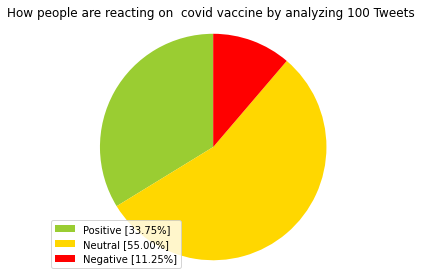

In [ ]:
## Print the Pie Chart ##
    
labels = ['Positive ['+str(positive)+'%]', 
          'Neutral ['+str(neutral)+'%]', 
          'Negative ['+str(negative)+'%]']

sizes = [positive, neutral, negative]
colors = ['yellowgreen', 'gold', 'red']
patches, texts = plt.pie(sizes, colors = colors, startangle = 90)
plt.legend(patches, labels, loc = "best")
plt.title('How people are reacting on  '
          +searchTerm+' by analyzing '
          +str(NoOfTerms)+' Tweets ')
plt.axis('equal')
plt.tight_layout()
plt.show()

Getting top 5 positive tweets:

In [ ]:
top5pos = df.nlargest(5, ['Polarity'])

In [ ]:
top5pos.drop([0,'Time','Cleaned','cleaned_reviews','Stemmed','StemmedJoined'], 1)

,Text,Polarity
99,"RT @CDCgov: #COVID19 vaccines are safe and effective. \n \nMore than 73 million people have already received COVID-19 vaccines, which are und…",0.500000
34,@Balix15 Would love to get the vaccine but I’m not in the age category of priority right now. I’m also not pro lock… https://t.co/LjIbrGinEn,0.392857
77,"RT @drmwarner: Sask mandating 3h paid leave for employees to get vaccinated.\n\n@ongov, it's time to implement ""Special Vaccination Leave"" in…",0.357143
79,"RT @NICentenary2021: Alliance, Sinn Fein and the SDLP were all quick off the mark to criticise the UK approach to Covid, including criticis…",0.333333
62,RT @MirMAKOfficial: Was Just Informed That @HamidMirPAK Already Received His First Shot Of Covid Vaccine. \n\nIs it true Hamid ?,0.300000


Getting top 10 positive tweets:

In [ ]:
top10pos = df.nlargest(10, ['Polarity'])

In [ ]:
top10pos.drop([0,'Time','Cleaned','cleaned_reviews','Stemmed','StemmedJoined'], 1)

,Text,Polarity
99,"RT @CDCgov: #COVID19 vaccines are safe and effective. \n \nMore than 73 million people have already received COVID-19 vaccines, which are und…",0.500000
34,@Balix15 Would love to get the vaccine but I’m not in the age category of priority right now. I’m also not pro lock… https://t.co/LjIbrGinEn,0.392857
77,"RT @drmwarner: Sask mandating 3h paid leave for employees to get vaccinated.\n\n@ongov, it's time to implement ""Special Vaccination Leave"" in…",0.357143
79,"RT @NICentenary2021: Alliance, Sinn Fein and the SDLP were all quick off the mark to criticise the UK approach to Covid, including criticis…",0.333333
62,RT @MirMAKOfficial: Was Just Informed That @HamidMirPAK Already Received His First Shot Of Covid Vaccine. \n\nIs it true Hamid ?,0.300000
45,"RT @SkyNews: ""The European regulator has been clear throughout that this is safe and effective.""\n\n@MattHancock says he is ""very, very glad""…",0.275000
3,COVID 19 has robbed loved 1s from so many people including the SSD family. Recent I attended the funeral of 1 of ou… https://t.co/Uq1R8aD3Ze,0.250000
20,RT @TheSpiceQueen_: First Baby Born With COVID Antibodies After Mom Got the Moderna Vaccine | https://t.co/xgOUkPioT0 https://t.co/C8OFL4OB…,0.250000
60,"RT @CornwallCouncil: 👩‍⚕️💉 An amazing 254,725 people in Cornwall have now had their first dose of the Covid-19 vaccine 💪\n\nYou're making Cor…",0.250000
67,RT @MillicentOmanga: Your favourite senator receiving COVID-19 vaccine shot earlier today. It's safe and I reccomend it to all Kenyans. Now…,0.250000


Getting top 5 negative tweets:

In [ ]:
top5neg = df.nsmallest(5, ['Polarity'])

In [ ]:
top5neg.drop([0,'Time','Cleaned','cleaned_reviews','Stemmed','StemmedJoined'], 1)

,Text,Polarity
23,"@nwandu_charles @manmustwack Yes, he did.\nHe brought up lots of stupid theories against vaccine and covid and deceived lots of people.",-0.80
44,"RT @ReadMoreBible: I just recovered from a pretty bad case of Covid, and if given the choice NOW between Covid and the vaccine,\n.....I woul…",-0.70
94,RT @nhsrcofficial: Prime Minister Imran Khan was not fully vaccinated when he contracted the virus. He only got the 1st dose and merely 2 d…,-0.50
14,RT @atmccann: been thinking a lot about vaccine inequality lately — this piece is the result of working with NYT reporters across more than…,-0.30
50,RT @CLGuelphWell: Feeling a little #anxious about the COVID Vaccine? Health Care Access Research and Developmental Disabilities Program and…,-0.25


Getting top 10 negative tweets:

In [ ]:
top10neg = df.nsmallest(10, ['Polarity'])

In [ ]:
top10neg.drop([0,'Time','Cleaned','cleaned_reviews','Stemmed','StemmedJoined'], 1)

,Text,Polarity
23,"@nwandu_charles @manmustwack Yes, he did.\nHe brought up lots of stupid theories against vaccine and covid and deceived lots of people.",-0.800000
44,"RT @ReadMoreBible: I just recovered from a pretty bad case of Covid, and if given the choice NOW between Covid and the vaccine,\n.....I woul…",-0.700000
94,RT @nhsrcofficial: Prime Minister Imran Khan was not fully vaccinated when he contracted the virus. He only got the 1st dose and merely 2 d…,-0.500000
14,RT @atmccann: been thinking a lot about vaccine inequality lately — this piece is the result of working with NYT reporters across more than…,-0.300000
50,RT @CLGuelphWell: Feeling a little #anxious about the COVID Vaccine? Health Care Access Research and Developmental Disabilities Program and…,-0.250000
88,"RT @AntonioSabatojr: I will never take any covid vaccine, plain and simple.",-0.214286
76,RT @HSEImm: Updated versions of the COVID-19 Vaccine AstraZeneca® materials on @HSELive website\n\nPlease destroy any stock of previous versi…,-0.183333
39,"RT @CBSNews: Almost half of all health care workers in U.S. haven't had COVID-19 vaccine, survey shows https://t.co/rptZOdYY35",-0.166667
38,RT @NassauExecutive: VACCINE MILESTONE: 30% of the total Nassau County population has received at least one shot of the COVID-19 vaccine –…,-0.150000
0,RT @TheEliKlein: Nobody has inspired more Covid vaccine hesitancy than Anthony Fauci,0.000000


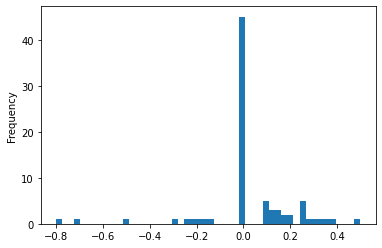

In [ ]:
df['Polarity'].plot(bins=50, kind='hist') 

# Topic Modelling using LDA and visualization using pyLDAvis

In [ ]:
pip install pyLDAvis

     |████████████████████████████████| 1.7MB 12.2MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-3.2.2-py2.py3-none-any.whl size=135593 sha256=c6a5f217eb9bc2bfec295cb8da950e9dff726016d36386875c2e49e61ab44bc9
  Stored in directory: /root/.cache/pip/wheels/74/df/b6/97234c8446a43be05c9a8687ee0db1f1b5ade5f27729187eae
Successfully built pyLDAvis


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# !pip install --upgrade gensim
import gensim
from gensim import corpora, models
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim
import time

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


In [ ]:
corpus = df['Stemmed']
dictionary = gensim.corpora.Dictionary(corpus)

# BOW corpus
bow_corpus = [dictionary.doc2bow(doc) for doc in corpus]

# TDIDF corpus
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

In [ ]:
for a,b in dictionary.iteritems():
    print(a, b)
    if a == 10:
        break

0 can
1 covid
2 dear
3 ie
4 instanc
5 ivermectin
6 peopl
7 request
8 t
9 treatment
10 vaccin


In [ ]:
def get_coherence(model):
    coherence_model_lda = CoherenceModel(model=model, texts=corpus, dictionary=dictionary, coherence='c_v')
    return coherence_model_lda.get_coherence()

In [ ]:
all_models = {}
coherences = []

start_time = time.time()

lda = gensim.models.LdaMulticore(bow_corpus, id2word=dictionary, num_topics=3, chunksize=1, passes=2)
model_description = 'Bow corpus, 2 passes, 3 topics'
all_models[model_description] = lda
coherences.append(get_coherence(lda))

for idx, topic in lda.print_topics(-1):
#     print('Topic: {} \nWords: {}'.format(idx, topic))
    print(topic)
    print('------------------------------------------------------------------------------------------------------------')
    
print(time.time() - start_time)

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

0.106*"covid" + 0.098*"vaccin" + 0.026*"dose" + 0.021*"elig" + 0.019*"got" + 0.018*"hospit" + 0.017*"chines" + 0.015*"first" + 0.015*"receiv" + 0.013*"health"
------------------------------------------------------------------------------------------------------------
0.042*"’" + 0.023*"s" + 0.015*"school" + 0.015*"hard" + 0.015*"“" + 0.012*"roll" + 0.010*"programm" + 0.009*"”" + 0.009*"‘" + 0.008*"it"
------------------------------------------------------------------------------------------------------------
0.021*"condit" + 0.020*"avail" + 0.018*"time" + 0.016*"easi" + 0.016*"fight" + 0.016*"come" + 0.016*"citizen" + 0.016*"t…" + 0.016*"win" + 0.016*"step"
------------------------------------------------------------------------------------------------------------
0.923865795135498


In [ ]:
pyLDAvis.enable_notebook()
lda = all_models['Bow corpus, 2 passes, 3 topics']
vis = pyLDAvis.gensim.prepare(lda, bow_corpus, dictionary, mds='mmds')
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.057409  0.136664  1       1        47.272510
1      0.065165 -0.111471  2       1        32.998995
2     -0.122574 -0.025192  3       1        19.728495, topic_info=        Term       Freq      Total Category  logprob  loglift
1    covid    53.000000  53.000000  Default  30.0000  30.0000
10   vaccin   49.000000  49.000000  Default  29.0000  29.0000
12   ’        14.000000  14.000000  Default  28.0000  28.0000
225  s        8.000000   8.000000   Default  27.0000  27.0000
53   dose     13.000000  13.000000  Default  26.0000  26.0000
..    ...           ...        ...      ...      ...      ...
588  produc   1.912964   3.567568   Topic3  -4.6924   0.9999 
589  readi    1.912964   3.567568   Topic3  -4.6924   0.9999 
590  they…    1.912964   3.567568   Topic3  -4.6924   0.9999 
561  fight    3.395008   6.881373   Topic3  -4.1187   0.9166 
139  citizen  3.370542   9.038628   Topic3  -4.1260   0.6367 

[149 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
543   2      0.548562  act        
166   1      0.251244  amp        
166   3      0.753732  amp        
415   1      0.302239  astrazeneca
415   3      0.604477  astrazeneca
...  ..           ...          ...
569   2      0.583016  𝘁𝗵𝗲        
569   3      0.291508  𝘁𝗵𝗲        
570   1      0.291508  𝘂𝗻𝗱𝗲𝗿      
570   2      0.583016  𝘂𝗻𝗱𝗲𝗿      
570   3      0.291508  𝘂𝗻𝗱𝗲𝗿      

[179 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3])

# Machine Learning Models for Text Classification:

## Multinomial NB:

**Importing csv file after adding hand tagged sentiemnt of each tweet: +1 for positive tweet, 0 for neutral and -1 for negative tweet. **

In [ ]:
data = pd.read_csv('vaccine.csv')

In [ ]:
data.head()

,Unnamed: 0,0,Time,Text,Cleaned,cleaned_reviews,Stemmed,StemmedJoined,label
0,0,"FDA, CDC advisers say to expect a lot of questions about AstraZeneca COVID-19 vaccine https://t.co/3XSLXjL4OV",3/19/21 15:17,"FDA, CDC advisers say to expect a lot of questions about AstraZeneca COVID-19 vaccine https://t.co/3XSLXjL4OV",fda cdc advisers say expect lot questions astrazeneca covid vaccine,"['fda', 'cdc', 'advisers', 'say', 'expect', 'lot', 'questions', 'astrazeneca', 'covid', 'vaccine']","['fda', 'cdc', 'advis', 'say', 'expect', 'lot', 'question', 'astrazeneca', 'covid', 'vaccin']",fda cdc advis say expect lot question astrazeneca covid vaccin,0
1,1,"RT @thedailybeast: On this 100th episode of the @NewAbnormalPod, @MollyJongFast also speaks to @RepAuchincloss about the pandemic and how t…",3/19/21 15:17,"RT @thedailybeast: On this 100th episode of the @NewAbnormalPod, @MollyJongFast also speaks to @RepAuchincloss about the pandemic and how t…",th episode also speaks pandemic t…,"['th', 'episode', 'also', 'speaks', 'pandemic', 't…']","['th', 'episod', 'also', 'speak', 'pandem', 't…']",th episod also speak pandem t…,0
2,2,"RT @lhfang: Pfizer, Moderna, Johnson &amp; Johnson have told investors they will hike prices on vaccines soon and cash in as covid vaccines may…",3/19/21 15:17,"RT @lhfang: Pfizer, Moderna, Johnson &amp; Johnson have told investors they will hike prices on vaccines soon and cash in as covid vaccines may…",pfizer moderna johnson amp johnson told investors hike prices vaccines soon cash covid vaccines may…,"['pfizer', 'moderna', 'johnson', 'amp', 'johnson', 'told', 'investors', 'hike', 'prices', 'vaccines', 'soon', 'cash', 'covid', 'vaccines', 'may…']","['pfizer', 'moderna', 'johnson', 'amp', 'johnson', 'told', 'investor', 'hike', 'price', 'vaccin', 'soon', 'cash', 'covid', 'vaccin', 'may…']",pfizer moderna johnson amp johnson told investor hike price vaccin soon cash covid vaccin may…,-1
3,3,Covid: What’s the problem with the EU vaccine rollout? https://t.co/G7NRWl39Fm https://t.co/z0h34vVVfy,3/19/21 15:17,Covid: What’s the problem with the EU vaccine rollout? https://t.co/G7NRWl39Fm https://t.co/z0h34vVVfy,covid what’s problem eu vaccine rollout,"['covid', 'what', '’', 's', 'problem', 'eu', 'vaccine', 'rollout']","['covid', 'what', '’', 's', 'problem', 'eu', 'vaccin', 'rollout']",covid what ’ s problem eu vaccin rollout,0
4,4,RT @thetimesscot: People who develop unusual bruising or a headache that persists more than a few days after vaccination should seek medica…,3/19/21 15:17,RT @thetimesscot: People who develop unusual bruising or a headache that persists more than a few days after vaccination should seek medica…,people develop unusual bruising headache persists days vaccination seek medica…,"['people', 'develop', 'unusual', 'bruising', 'headache', 'persists', 'days', 'vaccination', 'seek', 'medica…']","['peopl', 'develop', 'unusu', 'bruis', 'headach', 'persist', 'day', 'vaccin', 'seek', 'medica…']",peopl develop unusu bruis headach persist day vaccin seek medica…,-1


In [ ]:
data['length'] = data['StemmedJoined'].apply(len)
data.head()

,Unnamed: 0,0,Time,Text,Cleaned,cleaned_reviews,Stemmed,StemmedJoined,label,length
0,0,"FDA, CDC advisers say to expect a lot of questions about AstraZeneca COVID-19 vaccine https://t.co/3XSLXjL4OV",3/19/21 15:17,"FDA, CDC advisers say to expect a lot of questions about AstraZeneca COVID-19 vaccine https://t.co/3XSLXjL4OV",fda cdc advisers say expect lot questions astrazeneca covid vaccine,"['fda', 'cdc', 'advisers', 'say', 'expect', 'lot', 'questions', 'astrazeneca', 'covid', 'vaccine']","['fda', 'cdc', 'advis', 'say', 'expect', 'lot', 'question', 'astrazeneca', 'covid', 'vaccin']",fda cdc advis say expect lot question astrazeneca covid vaccin,0,62
1,1,"RT @thedailybeast: On this 100th episode of the @NewAbnormalPod, @MollyJongFast also speaks to @RepAuchincloss about the pandemic and how t…",3/19/21 15:17,"RT @thedailybeast: On this 100th episode of the @NewAbnormalPod, @MollyJongFast also speaks to @RepAuchincloss about the pandemic and how t…",th episode also speaks pandemic t…,"['th', 'episode', 'also', 'speaks', 'pandemic', 't…']","['th', 'episod', 'also', 'speak', 'pandem', 't…']",th episod also speak pandem t…,0,30
2,2,"RT @lhfang: Pfizer, Moderna, Johnson &amp; Johnson have told investors they will hike prices on vaccines soon and cash in as covid vaccines may…",3/19/21 15:17,"RT @lhfang: Pfizer, Moderna, Johnson &amp; Johnson have told investors they will hike prices on vaccines soon and cash in as covid vaccines may…",pfizer moderna johnson amp johnson told investors hike prices vaccines soon cash covid vaccines may…,"['pfizer', 'moderna', 'johnson', 'amp', 'johnson', 'told', 'investors', 'hike', 'prices', 'vaccines', 'soon', 'cash', 'covid', 'vaccines', 'may…']","['pfizer', 'moderna', 'johnson', 'amp', 'johnson', 'told', 'investor', 'hike', 'price', 'vaccin', 'soon', 'cash', 'covid', 'vaccin', 'may…']",pfizer moderna johnson amp johnson told investor hike price vaccin soon cash covid vaccin may…,-1,94
3,3,Covid: What’s the problem with the EU vaccine rollout? https://t.co/G7NRWl39Fm https://t.co/z0h34vVVfy,3/19/21 15:17,Covid: What’s the problem with the EU vaccine rollout? https://t.co/G7NRWl39Fm https://t.co/z0h34vVVfy,covid what’s problem eu vaccine rollout,"['covid', 'what', '’', 's', 'problem', 'eu', 'vaccine', 'rollout']","['covid', 'what', '’', 's', 'problem', 'eu', 'vaccin', 'rollout']",covid what ’ s problem eu vaccin rollout,0,40
4,4,RT @thetimesscot: People who develop unusual bruising or a headache that persists more than a few days after vaccination should seek medica…,3/19/21 15:17,RT @thetimesscot: People who develop unusual bruising or a headache that persists more than a few days after vaccination should seek medica…,people develop unusual bruising headache persists days vaccination seek medica…,"['people', 'develop', 'unusual', 'bruising', 'headache', 'persists', 'days', 'vaccination', 'seek', 'medica…']","['peopl', 'develop', 'unusu', 'bruis', 'headach', 'persist', 'day', 'vaccin', 'seek', 'medica…']",peopl develop unusu bruis headach persist day vaccin seek medica…,-1,65


In [ ]:
data.describe()

,Unnamed: 0,label,length
count,83.000000,83.000000,83.000000
mean,46.349398,0.000000,67.168675
std,28.364971,0.748983,17.973435
min,0.000000,-1.000000,16.000000
25%,22.500000,-1.000000,57.000000
50%,45.000000,0.000000,71.000000
75%,69.000000,1.000000,80.000000
max,98.000000,1.000000,101.000000


Split data into 80% train and 20% test.

In [ ]:
from sklearn.model_selection import train_test_split

rev_train, rev_test, score_train, score_test =\
train_test_split(data['StemmedJoined'], data['label'], test_size=0.2)

print(len(rev_train), len(rev_test), len(rev_train) + len(rev_test))

66 17 83


Uni-gram Model:

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer

pipe = Pipeline([
    ('bow', CountVectorizer(ngram_range=(1,1))),  
    ('tfidf', TfidfTransformer()),  
    ("clf_linearSVC", MultinomialNB()),  
])

pipe.fit(rev_train,score_train)

predicted = pipe.predict(rev_test)
print(classification_report(predicted,score_test))

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         2
           0       0.55      0.67      0.60         9
           1       0.50      0.33      0.40         6

    accuracy                           0.47        17
   macro avg       0.35      0.33      0.33        17
weighted avg       0.47      0.47      0.46        17



Bi-gram Model:

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer

pipe2 = Pipeline([
    ('bow', CountVectorizer(ngram_range=(2,3))),  
    ('tfidf', TfidfTransformer()),  
    ("clf_linearSVC", MultinomialNB()),  
])

pipe2.fit(rev_train,score_train)

predicted = pipe2.predict(rev_test)
print(classification_report(predicted,score_test))

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           0       0.91      0.62      0.74        16
           1       0.00      0.00      0.00         1

    accuracy                           0.59        17
   macro avg       0.30      0.21      0.25        17
weighted avg       0.86      0.59      0.70        17



## Support Vector Machine:

Uni-gram Model:

In [ ]:
from sklearn.svm import LinearSVC

clf_linearSVC_pipe = Pipeline([
    ('bow', CountVectorizer(ngram_range=(1,1))),  
    ('tfidf', TfidfTransformer()),  
    ("clf_linearSVC", LinearSVC()),  
])

clf_linearSVC_pipe.fit(rev_train,score_train)

predictedLinearSVC = clf_linearSVC_pipe.predict(rev_test)
print(classification_report(predictedLinearSVC,score_test))

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         3
           0       0.45      0.71      0.56         7
           1       0.75      0.43      0.55         7

    accuracy                           0.47        17
   macro avg       0.40      0.38      0.37        17
weighted avg       0.50      0.47      0.45        17



Bi-gram Model:

In [ ]:
from sklearn.svm import LinearSVC

clf_linearSVC_pipe = Pipeline([
    ('bow', CountVectorizer(ngram_range=(2,3))),  
    ('tfidf', TfidfTransformer()),  
    ("clf_linearSVC", LinearSVC()),  
])

clf_linearSVC_pipe.fit(rev_train,score_train)

predictedLinearSVC = clf_linearSVC_pipe.predict(rev_test)
print(classification_report(predictedLinearSVC,score_test))

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           0       0.82      0.69      0.75        13
           1       0.25      0.25      0.25         4

    accuracy                           0.59        17
   macro avg       0.36      0.31      0.33        17
weighted avg       0.68      0.59      0.63        17



## Decision Trees

Uni-gram Model:

In [ ]:
from sklearn.tree import DecisionTreeClassifier

clf_decisionTree_pipe = Pipeline([
    ('bow', CountVectorizer(ngram_range=(1, 1))),  
    ('tfidf', TfidfTransformer()),  
    ("clf_decisionTree", DecisionTreeClassifier()),  
])

clf_decisionTree_pipe.fit(rev_train,score_train)

predictedDecisionTree  = clf_decisionTree_pipe.predict(rev_test)
print(classification_report(predictedDecisionTree,score_test))

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           0       0.64      0.64      0.64        11
           1       0.25      0.17      0.20         6

    accuracy                           0.47        17
   macro avg       0.30      0.27      0.28        17
weighted avg       0.50      0.47      0.48        17



Bi-gram Model:

In [ ]:
from sklearn.tree import DecisionTreeClassifier

clf_decisionTree_pipe = Pipeline([
    ('bow', CountVectorizer(ngram_range=(2, 3))),  
    ('tfidf', TfidfTransformer()),  
    ("clf_decisionTree", DecisionTreeClassifier()),  
])

clf_decisionTree_pipe.fit(rev_train,score_train)

predictedDecisionTree  = clf_decisionTree_pipe.predict(rev_test)
print(classification_report(predictedDecisionTree,score_test))

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         9
           0       0.55      0.75      0.63         8
           1       0.00      0.00      0.00         0

    accuracy                           0.35        17
   macro avg       0.18      0.25      0.21        17
weighted avg       0.26      0.35      0.30        17



Creating pie chart of positive, neutral and negative tweets:

In [ ]:
positive = 0
negative = 0
neutral = 0
polarity = 0

for i in data['label']: 
   
    if(i == 0):
        neutral += 1
       
    elif(i < 0.00):
        negative += 1

    elif(i > 0.00):
        positive += 1

In [ ]:
def percentage(part, whole):
    return 100 * float(part)/float(whole)

In [ ]:
positive = percentage(positive, NoOfTweets)
negative = percentage(negative, NoOfTweets)
neutral  = percentage(neutral, NoOfTweets)
polarity  = percentage(polarity, NoOfTweets)

In [ ]:
# Limit the decimal upto 2 places #
positive = format(positive, '.2f')
negative = format(negative, '.2f')
neutral = format(neutral, '.2f')

In [ ]:
print(neutral)

41.11


In [ ]:
print("How people are reacting on " + searchTerm + 
      " By analyzing" + str(NoOfTerms) + " Tweets ")

if (polarity == 0):
    print("Neutral")
    
elif (polarity < 0.00):
    print("Negative")
    
elif (polarity > 0.00):
    print("Positive")

How people are reacting on covid vaccine By analyzing100 Tweets 
Neutral


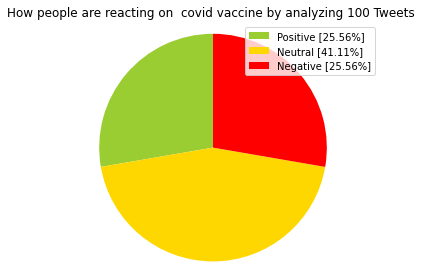

In [ ]:
labels = ['Positive ['+str(positive)+'%]', 
          'Neutral ['+str(neutral)+'%]', 
          'Negative ['+str(negative)+'%]']

sizes = [positive, neutral, negative]
colors = ['yellowgreen', 'gold', 'red']
patches, texts = plt.pie(sizes, colors = colors, startangle = 90)
plt.legend(patches, labels, loc = "best")
plt.title('How people are reacting on  '
          +searchTerm+' by analyzing '
          +str(NoOfTerms)+' Tweets ')
plt.axis('equal')
plt.tight_layout()
plt.show()

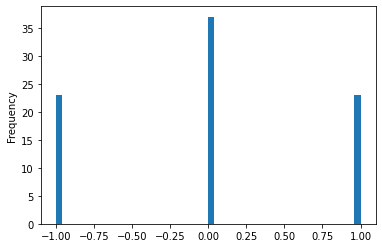

In [ ]:
data['label'].plot(bins=50, kind='hist') 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbdf54c1a50>,
      dtype=object)

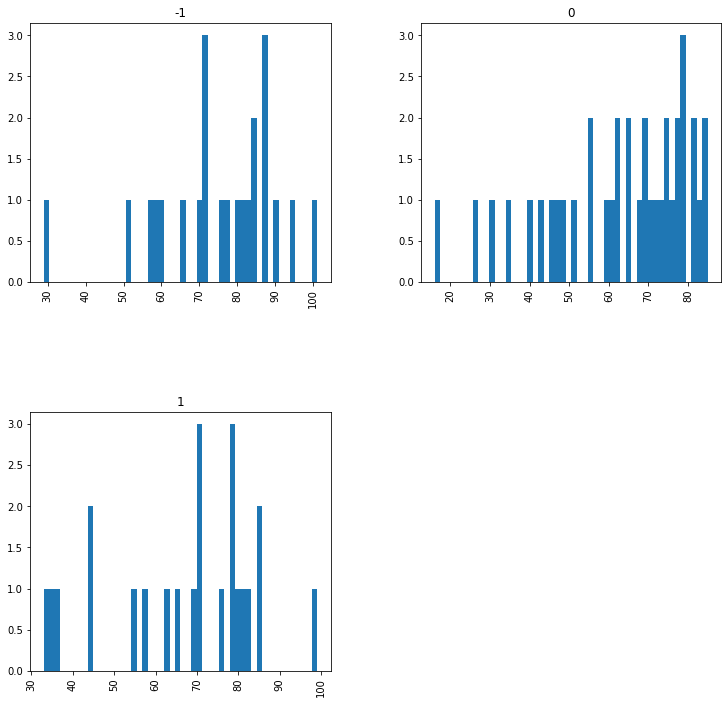

In [ ]:
data.hist(column='length', by='label', bins=50,figsize=(12,12))